In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utils import *


In [2]:
path_m5 = "./"
df_all = pd.read_csv(path_m5+"sales_ms_all_prophet.csv")
df_cat = pd.read_csv(path_m5+"sales_ms_cat_prophet.csv")

In [3]:
split_date = "2015-05-01"

In [4]:
target = 'error'

In [62]:
variables_constrains = {}
variables_constrains['discount_pct'] = 1
variables_constrains['sell_price'] = -1
variables_constrains['full_price'] = -1
variables_constrains['yhat'] = 0
variables_constrains['yhat_lower'] = 0
variables_constrains['yhat_upper'] = 0
variables_constrains['wday'] = 0
variables_constrains['month'] = 0
variables = list(variables_constrains.keys())
monotonic_vector = list(variables_constrains.values())

In [63]:
df_train = df_all[df_all["ds"]<split_date]
df_test = df_all[df_all["ds"]>=split_date]

In [64]:
df_train = df_cat[df_cat["ds"]<split_date]
df_test = df_cat[df_cat["ds"]>=split_date]

In [65]:
dtrain = lgb.Dataset(df_train[variables], label=df_train[target].values,
                      feature_name=variables, free_raw_data=False)  
dvalid = lgb.Dataset(df_test[variables], label=df_test[target].values,
                      feature_name=variables, free_raw_data=False)

In [80]:
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'monotone_constraints' : monotonic_vector,
        'metric':'rmse',
        'learning_rate': 0.01,
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 5,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.8,  # Subsample ratio of the training instance.
        'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 1,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        #'subsample_for_bin': 20000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0}

In [81]:
evals_results = {}
lgb_model = lgb.train(lgb_params, dtrain, valid_sets=[dtrain, dvalid], 
                      valid_names=['train','valid'], evals_result=evals_results,
                      num_boost_round=3000, early_stopping_rounds=20, verbose_eval=1)

[1]	train's rmse: 1562.11	valid's rmse: 1745.86
Training until validation scores don't improve for 20 rounds
[2]	train's rmse: 1560.98	valid's rmse: 1745.48
[3]	train's rmse: 1559.65	valid's rmse: 1744.5
[4]	train's rmse: 1558.54	valid's rmse: 1743.93
[5]	train's rmse: 1557.35	valid's rmse: 1743.34
[6]	train's rmse: 1556.2	valid's rmse: 1742.81
[7]	train's rmse: 1555.09	valid's rmse: 1743.07
[8]	train's rmse: 1553.9	valid's rmse: 1742.68
[9]	train's rmse: 1552.97	valid's rmse: 1743.4
[10]	train's rmse: 1551.79	valid's rmse: 1742.48
[11]	train's rmse: 1550.87	valid's rmse: 1742.88
[12]	train's rmse: 1549.76	valid's rmse: 1742.48
[13]	train's rmse: 1548.62	valid's rmse: 1741.6
[14]	train's rmse: 1547.42	valid's rmse: 1741.22
[15]	train's rmse: 1546.46	valid's rmse: 1740.75
[16]	train's rmse: 1545.42	valid's rmse: 1740.3
[17]	train's rmse: 1544.41	valid's rmse: 1740.2
[18]	train's rmse: 1543.48	valid's rmse: 1739.84
[19]	train's rmse: 1542.63	valid's rmse: 1740.08
[20]	train's rmse: 1541.

In [82]:
df_cat['predict_lgb'] = lgb_model.predict(df_cat[variables])
df_cat['prediccion_unidades_lgb'] = df_cat['yhat'] + df_cat['predict_lgb']

In [83]:
y_true = df_cat['y'].values
y_pred = df_cat['yhat'].values
print("Forecast Daily error Prophet category:")
print_metrics(y_true, y_pred)

Forecast Daily error Prophet category:
MAE 914.17
MSE 2564099.182
RMSE 1601.28
MAPE inf
SMAPE 0.079
MAAPE 0.078
R2 0.971


In [84]:
y_true = df_cat['y'].values
y_pred = df_cat['prediccion_unidades_lgb'].values
print("Forecast Daily error Prophet+LightGBM category:")
print_metrics(y_true, y_pred)

Forecast Daily error Prophet+LightGBM category:
MAE 902.49
MSE 2490101.886
RMSE 1578.006
MAPE inf
SMAPE 0.078
MAAPE 0.077
R2 0.971


In [85]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance('gain'),'Feature':X.columns})
    sns.set_palette(sns.color_palette("tab10"))
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

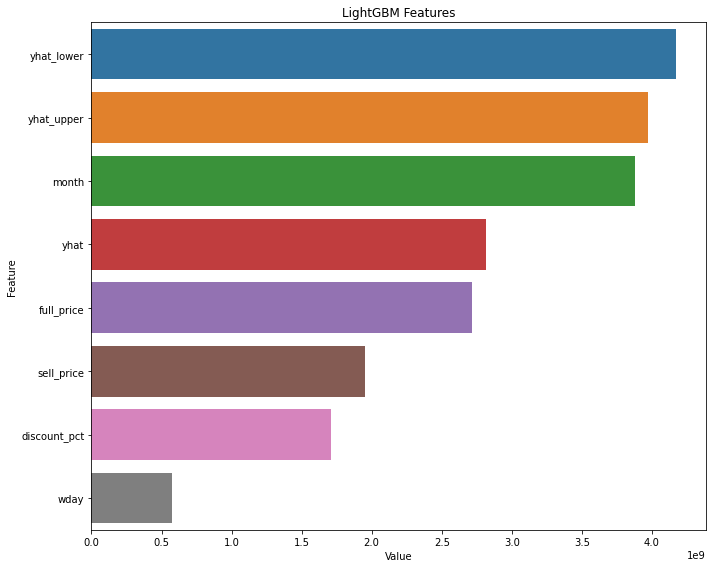

In [86]:
plotImp(lgb_model, df_train[variables], 20)